# Preparing Data for Fine-tuning a NER Model
started Oct 17th, last edit: Oct 19th

In [1]:
import pandas as pd
import re
from bs4 import BeautifulSoup
import numpy as np
import os
from tqdm import tqdm

## 1. **Data/Label Collection**
- Reading in htmls, extracting text and table from it
- Reading in labels extracted by NED figuring out where in the text/table they come from
- Add the location in text/table as an extra column to the label file (to be used for annotation).
- If labeled dataset is insufficient, we should consider augmenting it with more representative examples.


In [2]:
def clean_string(s):
    """Clean the string by retaining only alphabetical and numerical values and converting to lowercase."""
    return re.sub(r'[^a-zA-Z0-9]', '', s).lower()

def generate_variants(s):
    """Generate various forms of the string."""
    s = str(s).strip()
    cleaned = clean_string(s)
    with_dash = s.replace(' ', '-')
    with_mdash = s.replace(' ', '_')
    without_mdash = s.replace('-',' ')
    withou_dash = s.replace('_', ' ')
    nospace = s.replace(' ','')
    variants = [s, cleaned, with_dash, with_mdash,nospace,withou_dash,without_mdash]
    return variants

def cleantable(df):
    '''change multi-index column to single and 
    Iterate through each row and column in the DataFrame to remove non byte like characters'''
    
    df.columns = [' '.join(col).strip() for col in df.columns.values]
    for index, row in df.iterrows():
        for col in df.columns:
            df.at[index, col] = re.sub('[^a-zA-Z0-9]', '', str(row[col]))
    return df

def clean_tables_list(tables_list):
    '''Iterate over a list of tables and apply cleantable function to each one'''
    return [cleantable(df) for df in tables_list]

def get_html_tables(f):
    with open(f) as file:
        soup = BeautifulSoup(file, 'html.parser')
    try:
        tables = pd.read_html(str(soup))
        clean_tables_list(tables)
        return tables
    except:
        #print('no table in'+str(f))
        pass
    
def get_html_text(f,plength=100):
    with open(f) as file:
        soup = BeautifulSoup(file, 'html.parser')
        
    #to inspect html and identify the class label
    #print(soup.prettify()) 
    
    sections = soup.find_all('div', class_="article-text")

    # Extracting all paragraphs in the section
    paragraphs = soup.find_all('p')
    text = ''
    for i, para in enumerate(paragraphs):
        p = para.get_text()
        if (len(p)>plength) and (p[0].isalpha()):
            text+=p
            #print(f"Paragraph {i+1}:", p)
            #print('--------------')
    return text

def find_all(text, substring):
    return [match.start() for match in re.finditer(substring, text, re.IGNORECASE)]

def find_variant_in_text(sub, text):
    """Find the start and end index of a variant of 'sub' in 'text'."""
    ls =[]
    for variant in generate_variants(sub):
        start_index = find_all(text,variant)
        if start_index:  # This condition checks if the list is not empty
            for s in start_index:
                ls.append((s, s + len(variant)))
    return ls if ls else None

def find_variant_in_tables(sub, tables_list):
    """Find all table numbers, row indices, and column names where a variant of 'sub' exists."""
    locations = []
    
    for variant in generate_variants(str(sub)):
        for table_num, table in enumerate(tables_list, 1):
            locs = table.isin([variant]).stack()
            matched_locs = locs[locs == True].index.tolist()
            for row, col in matched_locs:
                locations.append((table_num, row, col))
                
    return locations if locations else None
    
def add_location_columns(df, text,tables_list,colname='ap_name1'):
    """Add 'Location' column to DataFrame based on the 'ap_name1' column values' appearance in the text."""
    if colname in df.columns:
        df[colname+'_Loc_in_text'] = df[colname].apply(lambda cell: find_variant_in_text(cell, text) if pd.notna(cell) else None)

        if tables_list:
            df[colname+'_Loc_in_table'] = df[colname].apply(lambda cell: find_variant_in_tables(cell, tables_list) if pd.notna(cell) else None)
        else:
            df[colname+'_Loc_in_table'] = None
    return df
    

In [3]:
directory = 'data/2022ApJ_PREPFILES/'
outdir = 'data/lable_locations/'

count = 0
for prepfilename in tqdm(os.listdir(directory)):
    if count>1000:
        break
    prepfilepath = os.path.join(directory, prepfilename)
    if os.path.isfile(prepfilepath):
        
        # Read in label file 
        labeldf = pd.read_csv(prepfilepath, delimiter="|", skipinitialspace=True, low_memory=False)
        labeldf.columns = labeldf.columns.str.strip()
        

        try:
            # Read in html sections and tables
            s = prepfilename.split('.')
            htmldir = 'data/'+s[0][0:4]+'-'+s[0][4:]+'-Vol'+s[3][0:3]+'/HTML/'
            htmlfilepath = os.path.join(htmldir, prepfilename[0:19]+'.html')
            texts = get_html_text(htmlfilepath)
            tables = get_html_tables(htmlfilepath)
            
            #find where in section texts or table the labeled data are mentioned
            df = add_location_columns(labeldf,texts,tables,colname='ap_name1')
            df = add_location_columns(labeldf,texts,tables,colname='name1')
            df = add_location_columns(labeldf,texts,tables,colname='vz1')
            df = add_location_columns(labeldf,texts,tables,colname='coordx1')
            df = add_location_columns(labeldf,texts,tables,colname='coordy1')
            
            df.to_csv(outdir+prepfilename[:-3]+'csv', index=False)
            count+=1
        except Exception as e:
            print('---in file:'+prepfilename+'---')
            print(f"An error occurred: {e}")
            print('---------------------------')
    


 15%|██████▏                                    | 135/930 [03:46<09:44,  1.36it/s]

---in file:2022ApJ...925L..20K_L20K.flt---
An error occurred: [Errno 2] No such file or directory: 'data/2022-ApJ-Vol925/HTML/2022ApJ...925L..20K.html'
---------------------------


 41%|██████████████▉                      | 377/930 [4:00:42<69:13:45, 450.68s/it]

---in file:2022ApJ...941...95W_A95W.flt---
An error occurred: [Errno 2] No such file or directory: 'data/2022-ApJ-Vol941/HTML/2022ApJ...941...95W.html'
---------------------------


100%|█████████████████████████████████████████| 930/930 [4:31:03<00:00, 17.49s/it]


### some statistics on the data at hand:

/var/folders/hj/vgpx3js504l063vxjx2cgbdm0005ym/T/ipykernel_22735/3146474726.py:26: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)
/var/folders/hj/vgpx3js504l063vxjx2cgbdm0005ym/T/ipykernel_22735/3146474726.py:26: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)
/var/folders/hj/vgpx3js504l063vxjx2cgbdm0005ym/T/ipykernel_22735/3146474726.py:26: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)
/var/folders/hj/vgpx3js504l063vxjx2cgbdm0005ym/T/ipykernel_22735/3146474726.py:26: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)
/var/folders/hj/vgpx3js504l063vxjx2cgbdm0005ym/T/ipykernel_22735/3146474726.py:26: DtypeWarning: Columns (2) have mixed types. Specify dtype option on i

Text(0, 0.5, 'number')

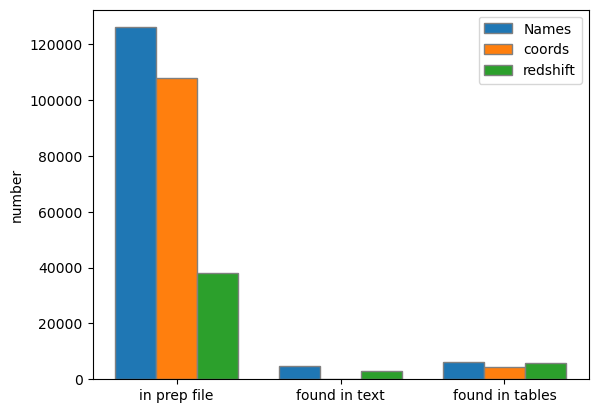

In [5]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
def count_rows_in_column(folder_path: str, column_name: str) -> int:
    """
    Counts non-empty rows in a specified column across all CSV files in a given folder.
    
    Args:
    - folder_path (str): Path to the folder containing CSV files.
    - column_name (str): Name of the column to count non-empty rows for.

    Returns:
    - int: Total count of non-empty rows for the specified column across all CSV files.
    """
    
    total_count = 0
    
    # Loop over all files in the folder
    for filename in os.listdir(folder_path):
        # Check if the file is a CSV
        if filename.endswith('.csv'):
            filepath = os.path.join(folder_path, filename)
            try:
                # Read the CSV file into a DataFrame
                df = pd.read_csv(filepath)
                
                # Check if the column exists
                if column_name in df.columns:
                    # Count non-empty rows (assuming NaN as empty)
                    count = df[column_name].count()
                    total_count += count
                    
            except Exception as e:
                print(f"Error reading {filename}: {e}")
                
    return total_count

labdir = 'data/lable_locations/'
# Columns you are interested in
coln = ['ap_name1', 'ap_name1_Loc_in_text','ap_name1_Loc_in_table']
colz = ['vz1', 'vz1_Loc_in_text','vz1_Loc_in_table']
colx = ['coordx1', 'coordx1_Loc_in_text','coordx1_Loc_in_table']

ncounts,zcounts,xcounts = [],[],[]
for c in range(len(coln)):
    ncounts.append(count_rows_in_column(labdir,coln[c]))
    xcounts.append(count_rows_in_column(labdir,colx[c]))
    zcounts.append(count_rows_in_column(labdir,colz[c]))
    
# Bar width and positions
barWidth = 0.25
r1 = np.arange(len(ncounts))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Create bars
plt.bar(r1, ncounts, width=barWidth, edgecolor='grey', label='Names')
plt.bar(r2, xcounts, width=barWidth, edgecolor='grey', label='coords')
plt.bar(r3, zcounts, width=barWidth, edgecolor='grey', label='redshift')
labels = ['in prep file','found in text','found in tables']
# Title & subtitle
plt.xticks([r + barWidth for r in range(len(ncounts))], labels)
plt.legend()
plt.ylabel('number')

## 2. **Annotation**
- Mark and label entities within your text.
- Entities to start with: `Object Name`, `RA`, `DEC`, `Redshift`, `Type`. We may add more later.
#### 2.1 **Figure out annotation formats**
Data can be represented in various formats:
- **BIO (or IOB) Format**
- **CoNLL Format**: Columns-based, used in datasets like CoNLL-2003. **will go with this for now**
- **Spacy Format**: JSON format (for Spacy users) with entities represented by start/end character positions.

Manual annotation can be time-consuming. If NED had not already done some part of this we could have considered: [Doccano](https://doccano.herokuapp.com/), [Prodigy](https://prodi.gy/) (by Spacy creators, paid), [Labelbox](https://www.labelbox.com/), or [Brat](http://brat.nlplab.org/). 

In [ ]:
text = "John S. Maro lives in New York and is tired. He is 27.2 years old"
entities = [("John S. Maro", "PERSON"), ("New York", "LOCATION"), ("27.2","AGE")]

# Step 1: Tokenize
tokens = text.split()  # Simplistic whitespace tokenization
labels = ['O'] * len(tokens)  # Step 2: Initialize with 'O' tags

# Step 3: Match entities and assign tags
for entity, entity_type in entities:
    entity_tokens = entity.split()
    for i in range(len(tokens) - len(entity_tokens) + 1):
        if tokens[i:i+len(entity_tokens)] == entity_tokens:
            labels[i] = "B-" + entity_type
            for j in range(1, len(entity_tokens)):
                labels[i+j] = "I-" + entity_type

# Step 4: Compile to CoNLL format
conll_data = "\n".join([f"{token} {label}" for token, label in zip(tokens, labels)])

print(conll_data)


In [9]:
df = pd.read_csv('data/lable_locations/2022ApJ...935...64E_A64E.csv')
labelcolumns = ['ap_name1_Loc_in_text', 'vz1_Loc_in_text','coordx1_Loc_in_text']
valuecolumns = ['ap_name1','vz1','coordx1']
for val,lab in zip(valuecolumns,labelcolumns):
    if lab in df.columns:
        for item1, item2 in zip(df[val], df[lab]):
            if pd.notna(item2):
                print(item1,item2)
        print("\n")

NGC 1365 [(1151, 1159), (7135, 7143), (11788, 11796), (28163, 28171), (35547, 35555), (1151, 1159), (7135, 7143), (11788, 11796), (28163, 28171), (35547, 35555), (1151, 1159), (7135, 7143), (11788, 11796), (28163, 28171), (35547, 35555)]
NGC 1300 [(6676, 6684), (25040, 25048), (6676, 6684), (25040, 25048), (6676, 6684), (25040, 25048)]




### 3. **Train/Test Split**
- Consider an 80% training, 10% validation, and 10% test split.
- Respect document boundaries to avoid overlap between sets.

### 4. **Preprocessing**
- Tokenize consistently with the pre-trained model's tokenization.
- Other steps might include converting to lowercase, handling punctuation, etc.

### 5. **Model-Specific Formatting**
- Convert data to be compatible with your chosen framework.
- For HuggingFace Transformers, use their `TokenClassification` model format.


### 6. **Augmentation (Optional)**
For smaller datasets, consider:
- Back translation
- Synonym replacement
- Sentence shuffling

### 7. **Data Quality Checks**
- Ensure annotation consistency.
- Address issues like overlapping annotations or mislabeled entities.

After data preparation, proceed with fine-tuning your NER model, evaluating on the validation set and tuning hyperparameters as needed.
